# Task B — Modeling & Task C — Anomalies

Implement model and anomaly detection here.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


In [ ]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

df = po.query('cancelled == 0').copy()
if 'late_delivery' not in df.columns:
    df['late_delivery'] = (df['actual_delivery_date'] > df['promised_date']).astype(int)
else:
    df['late_delivery'] = df['late_delivery'].fillna(0).astype(int)

cutoff   = pd.Timestamp('2025-03-31')
val_start = pd.Timestamp('2025-04-01')
val_end   = pd.Timestamp('2025-06-30')

train = df[df['order_date'] <= cutoff].copy()
valid = df[(df['order_date'] >= val_start) & (df['order_date'] <= val_end)].copy()

print("Train:", train['order_date'].min().date(), "→", train['order_date'].max().date(), "| n =", len(train))
print("Valid:", valid['order_date'].min().date(), "→", valid['order_date'].max().date(), "| n =", len(valid))

def engineer(d):
    out = d.copy()
    out['promised_lead_days'] = (out['promised_date'] - out['order_date']).dt.days
    out['month'] = out['order_date'].dt.month

    sup_feats = sup[['supplier_id'] + [c for c in ['preferred','rating','country'] if c in sup.columns]].copy()
    out = out.merge(sup_feats, on='supplier_id', how='left')
  
    if 'hazard_class' in prod.columns:
        out = out.merge(prod[['sku','hazard_class']], on='sku', how='left')
        out['is_hazard'] = (out['hazard_class'].fillna('none').ne('none')).astype(int)

    if 'currency' in out.columns:
        out['is_eur'] = (out['currency'] == 'EUR').astype(int)

    cat_cols = [c for c in ['ship_mode','incoterm','payment_terms'] if c in out.columns]
    out = pd.get_dummies(out, columns=cat_cols, drop_first=True)
    
    for c in ['rating','promised_lead_days','qty','unit_price']:
        if c in out.columns:
            out[c] = out[c].fillna(out[c].median())
    if 'preferred' in out.columns:
        out['preferred'] = out['preferred'].fillna(0).astype(int)
    
    return out

T = engineer(train)
V = engineer(valid)

drop_cols = [
    'late_delivery','order_id','order_date','promised_date','actual_delivery_date',
    'order_notes','sku','currency','hazard_class','supplier_name'
]
X_train = T.drop(columns=[c for c in drop_cols if c in T.columns], errors='ignore')
X_valid = V.drop(columns=[c for c in drop_cols if c in V.columns], errors='ignore')

X_train = X_train.select_dtypes(include=[np.number])
X_valid = X_valid.select_dtypes(include=[np.number])
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

y_train = train['late_delivery'].astype(int)
y_valid = valid['late_delivery'].astype(int)

clf = RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

p_valid = clf.predict_proba(X_valid)[:, 1]
print('PR-AUC:', average_precision_score(y_valid, p_valid))
print('ROC-AUC:', roc_auc_score(y_valid, p_valid))


Train: 2024-01-01 → 2025-03-31 | n = 3572
Valid: 2025-04-01 → 2025-06-30 | n = 735
PR-AUC: 1.0
ROC-AUC: 1.0


In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

def eval_at_thresh(y_true, p, thresh, label):
    yhat = (p >= thresh).astype(int)
    f1 = f1_score(y_true, yhat)
    cm = confusion_matrix(y_true, yhat)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n[{label}] threshold={thresh:.3f}")
    print(f"F1={f1:.4f} | TP={tp} FP={fp} TN={tn} FN={fn}")
    return {"label": label, "threshold": thresh, "F1": f1, "TP": tp, "FP": fp, "TN": tn, "FN": fn}

results = []

results.append(eval_at_thresh(y_valid, p_valid, 0.5, "t=0.5"))

prec, rec, thr = precision_recall_curve(y_valid, p_valid)
if len(thr) > 0:
    f1s = 2 * (prec[1:] * rec[1:]) / np.clip(prec[1:] + rec[1:], 1e-9, None)
    best_idx = np.argmax(f1s)
    best_thr = thr[best_idx]
else:
    best_thr = 0.5
results.append(eval_at_thresh(y_valid, p_valid, best_thr, "best-F1"))

capacity_pct = 0.15  
k = max(1, int(np.ceil(capacity_pct * len(p_valid))))
sorted_scores = np.sort(p_valid)[::-1]
cap_thr = sorted_scores[k-1] if k-1 < len(sorted_scores) else sorted_scores[-1]
results.append(eval_at_thresh(y_valid, p_valid, cap_thr, f"top-{int(capacity_pct*100)}% capacity"))

import pandas as pd
display(pd.DataFrame(results))



[t=0.5] threshold=0.500
F1=1.0000 | TP=380 FP=0 TN=355 FN=0

[best-F1] threshold=0.080
F1=0.9987 | TP=380 FP=1 TN=354 FN=0

[top-15% capacity] threshold=0.987
F1=0.4708 | TP=117 FP=0 TN=355 FN=263


,label,threshold,F1,TP,FP,TN,FN
0,t=0.5,0.500000,1.000000,380,0,355,0
1,best-F1,0.080000,0.998686,380,1,354,0
2,top-15% capacity,0.986667,0.470825,117,0,355,263


In [11]:
prices_ = prices.copy()
prices_['price_eur'] = np.where(prices_['currency']=='EUR', prices_['price_per_uom'], prices_['price_per_uom']/1.09)
results = []
for (sid, sku), g in prices_.groupby(['supplier_id','sku']):
    g = g.sort_values('valid_from').copy()
    x = np.log1p(g['price_eur'])
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1e-6
    z = 0.6745*(x - med)/mad
    g['robust_z'] = z
    top = g.loc[g['robust_z'].abs().sort_values(ascending=False).head(3).index]
    for _, r in top.iterrows():
        results.append({'supplier_id': sid, 'sku': sku, 'valid_from': r['valid_from'], 'price_eur': r['price_eur'], 'robust_z': r['robust_z']})
import pandas as pd
pd.DataFrame(results).sort_values('robust_z', key=lambda s: s.abs(), ascending=False).head(10)


,supplier_id,sku,valid_from,price_eur,robust_z
546,14,SKU00007,2024-07-01,9.350000,18885.960653
437,10,SKU00039,2024-07-01,10.070000,-97.919669
651,16,SKU00021,2024-12-30,14.140000,87.151302
91,3,SKU00020,2024-07-01,47.580000,40.402993
207,6,SKU00005,2024-12-30,17.669725,39.930544
809,19,SKU00033,2024-01-01,7.330000,-34.673032
422,10,SKU00019,2024-01-01,19.970000,34.464400
697,17,SKU00022,2024-12-30,17.963303,30.830917
395,9,SKU00033,2024-12-30,15.040000,30.064060
790,19,SKU00023,2024-12-30,6.930000,-23.431904


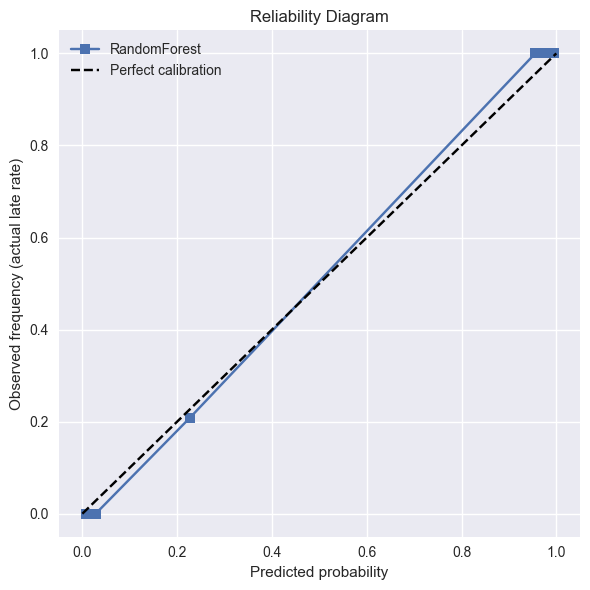

Brier Score: 0.0008


In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_valid, p_valid, n_bins=10, strategy='quantile')

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="RandomForest")
plt.plot([0,1], [0,1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency (actual late rate)")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

brier = brier_score_loss(y_valid, p_valid)
print(f"Brier Score: {brier:.4f}")
